<a href="https://colab.research.google.com/github/Florassss/118AFinal-Project/blob/master/3_training_and_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **3. Training and Testing**
Please start early! Section 3.6 Training may take one to two hours to run. 

## 3.0 Setup GDrive and Git

In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/content/gdrive') 

Mounted at /content/gdrive


In [2]:
# Make sure your token is stored in a txt file at the location below.
# This way there is no risk that you will push it to your repo
# Never share your token with anyone, it is basically your github password!
with open('/content/gdrive/MyDrive/ece5545/token.txt') as f:
    token = f.readline().strip()
# Use another file to store your github username    
with open('/content/gdrive/MyDrive/ece5545/git_username.txt') as f:
    handle = f.readline().strip()

In [3]:
# Clone your github repo
YOUR_TOKEN = token
YOUR_HANDLE = handle
BRANCH = "main"

%mkdir /content/gdrive/MyDrive/ece5545
%cd /content/gdrive/MyDrive/ece5545
!git clone https://{YOUR_TOKEN}@github.com/ML-HW-SYS/a2-{YOUR_HANDLE}.git
%cd /content/gdrive/MyDrive/ece5545/a2-{YOUR_HANDLE}
!git checkout {BRANCH}
!git pull
%cd /content/gdrive/MyDrive/ece5545

PROJECT_ROOT = f"/content/gdrive/MyDrive/ece5545/a2-{YOUR_HANDLE}"

mkdir: cannot create directory ‘/content/gdrive/MyDrive/ece5545’: File exists
/content/gdrive/MyDrive/ece5545
fatal: destination path 'a2-Florassss' already exists and is not an empty directory.
/content/gdrive/MyDrive/ece5545/a2-Florassss
Already on 'main'
Your branch is up to date with 'origin/main'.
Already up to date.
/content/gdrive/MyDrive/ece5545


In [4]:
# This extension reloads all imports before running each cell
%load_ext autoreload
%autoreload 2

### GPU

Ensure you are running the GPU runtime type:
1.   Click "Runtime" on top banner
2.   Select "Change runtime type"
3.   Under "Hardware accelarator" select "GPU" and save



### Import code dependencies

In [5]:
import os
import sys

# Adding assignment 2 to the system path
# -- make sure this matches your git directory
sys.path.insert(0, PROJECT_ROOT)

# Import libraries 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import copy

# Import constants to use constants defined for training
from src.constants import *
# Import data_proc to use data processing functions
import src.data_proc as data_proc

random_seed = 0
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

Model folders are created, 
PyTorch models will be saved in /content/gdrive/MyDrive/ece5545/models/torch_models, 
ONNX models will be saved in /content/gdrive/MyDrive/ece5545/models/onnx_models, 
TensorFlow Saved Models will be saved in /content/gdrive/MyDrive/ece5545/models/tf_models, 
TensorFlow Lite models will be saved in /content/gdrive/MyDrive/ece5545/models/tflite_models, 
TensorFlow Lite Micro models will be saved in /content/gdrive/MyDrive/ece5545/models/micro_models.


## 3.1 Download and Preprocess Data

### Create audio processor
This step is similar to what was done in part 2, so the files should already be downloaded in your Google Drive.

In [6]:
# Create audio_processor
audio_processor = data_proc.AudioProcessor()

### Select device: cuda or cpu

In [7]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device} to run the training scrpit.')

Using cpu to run the training scrpit.


## 3.2 Data Loader

In [8]:
# Define train, test, and validation set
train_set = audio_processor.data_index['training']
test_set = audio_processor.data_index['testing']
valid_set = audio_processor.data_index['validation']

# Define data loaders
from src.loaders import make_data_loaders
data_loaders = make_data_loaders(audio_processor, device)
train_loader = data_loaders['training']
test_loader = data_loaders['testing']
valid_loader = data_loaders['validation']

Train size: 10556 Val size: 1333 Test size: 1368


## 3.3 Define the Model

In [9]:
from src.networks import TinyConv
# Create a full precision (float32) TinyConv model
model_fp32 = TinyConv(
    model_settings=audio_processor.model_settings,
    n_input=1,
    n_output=audio_processor.num_labels
)
model_fp32

TinyConv(
  (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
  (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_reshape): Reshape(output_shape=(-1, 4000))
  (fc): Linear(in_features=4000, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

## 3.4 Training

In [10]:
from src.train_val_test_utils import train, test

### Adjust parameters
*   You can change *n_epoch* to use a different number training steps/epochs

In [11]:
num_batches = len(train_loader)
n_epoch = 50
print(f'# batches: {num_batches} \n# epochs: {n_epoch} \n# total training steps: {num_batches * n_epoch}')

# batches: 106 
# epochs: 50 
# total training steps: 5300


### Create optimizer for training
 Explore more at: 
[TORCH. OPTIM](https://pytorch.org/docs/stable/optim.html?highlight=torch%20optim%20lr_scheduler)

In [12]:
from src.train_val_test_utils import create_optimizer

# Create optimizer
optimizer_fp32 = create_optimizer(model=model_fp32, learning_rate=0.001)
print(optimizer_fp32.state_dict())

{'state': {}, 'param_groups': [{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0.0001, 'amsgrad': False, 'params': [0, 1, 2, 3]}]}


### Train the model
TensorBoard will allow you to visualize your results. The second code block, the training, will take a while to run.

In [13]:
pbar_update = 1 / (len(train_loader) + len(test_loader) + len(valid_loader))

def run_training(model, data_loaders, n_epoch, optimizer,
                 save_interval=1, resume=True, checkpoint_path=None):
    test_loader = data_loaders['testing']
    last_valacc = 0
    val_accs = []
    train_accs = []
    with tqdm(total=n_epoch) as pbar:
      
        completed_epoch = 1
        if resume:
            try:
                #continue training with previous model if one exists
                checkpoint = torch.load(checkpoint_path)
                model.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                completed_epoch = checkpoint["epoch"] + 1
                model.eval()
                pbar.update(completed_epoch)
            except:
                pass

        for epoch in range(completed_epoch, n_epoch + 1):
            valacc = 0
            train_iters = len(data_loaders['training'])
            
            train(model, data_loaders, optimizer, 
                      epoch, device)
            train_accs.append(test(train_loader, model, device, 
                     epoch=None, loader_type='Train'))
            #checkpoint the model every epoch
            if epoch % save_interval == 0 and valacc > last_valacc:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict()
                }, checkpoint_path)
            val_accs.append(valacc)
            # Update epoch pbar
            pbar.update(1)
        
        testacc = test(test_loader, model, device, 
                     epoch=None, loader_type='Test')
        print(f'Test Acc = {round(testacc,2)}%')
    return train_accs, val_accs

In [14]:

# This is where your checkpoint file will be saved
checkpoint_path = os.path.join(TORCH_DIR, "fp32_checkpoint.pt")

model_fp32.to(device)
train_accs, val_accs = run_training(
    model=model_fp32, data_loaders=data_loaders, 
    n_epoch=n_epoch, optimizer=optimizer_fp32, 
    resume=True, checkpoint_path=checkpoint_path
)

  0%|          | 0/50 [00:00<?, ?it/s]

Val Acc Epoch 1 = 82.0%, Train loss = 1.068
Val Acc Epoch 2 = 84.77%, Train loss = 0.557
Val Acc Epoch 3 = 86.65%, Train loss = 0.501
Val Acc Epoch 4 = 86.2%, Train loss = 0.465
Val Acc Epoch 5 = 86.87%, Train loss = 0.452
Val Acc Epoch 6 = 87.55%, Train loss = 0.438
Val Acc Epoch 7 = 88.07%, Train loss = 0.425
Val Acc Epoch 8 = 88.6%, Train loss = 0.416
Val Acc Epoch 9 = 88.3%, Train loss = 0.405
Val Acc Epoch 10 = 88.67%, Train loss = 0.405
Val Acc Epoch 11 = 87.7%, Train loss = 0.405
Val Acc Epoch 12 = 88.22%, Train loss = 0.407
Val Acc Epoch 13 = 89.27%, Train loss = 0.395
Val Acc Epoch 14 = 88.52%, Train loss = 0.398
Val Acc Epoch 15 = 88.22%, Train loss = 0.384
Val Acc Epoch 16 = 88.75%, Train loss = 0.381
Val Acc Epoch 17 = 86.42%, Train loss = 0.381
Val Acc Epoch 18 = 89.57%, Train loss = 0.377
Val Acc Epoch 19 = 89.35%, Train loss = 0.369
Val Acc Epoch 20 = 88.67%, Train loss = 0.377
Val Acc Epoch 21 = 89.35%, Train loss = 0.376
Val Acc Epoch 22 = 88.75%, Train loss = 0.366
Va

Text(0, 0.5, 'acc%')

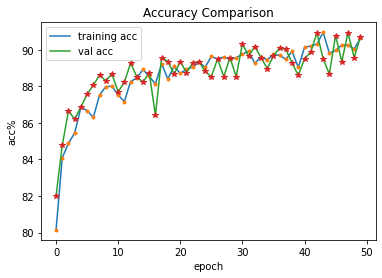

In [31]:
import matplotlib.pyplot as plt
plt.plot(np.arange(50), train_accs, label='training acc')
plt.plot(np.arange(50), train_accs, '.')

plt.plot(np.arange(50), val_accs,label='val acc')
plt.plot(np.arange(50), val_accs, '*')
plt.legend()
plt.title('Accuracy Comparison')
plt.xlabel('epoch')
plt.ylabel('acc%')


## 3.5 Testing

### Calculating accuracy


Train size: 10556 Val size: 1333 Test size: 1368


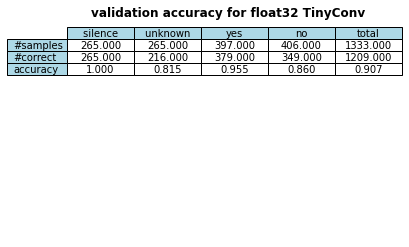

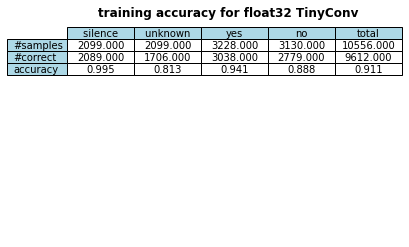

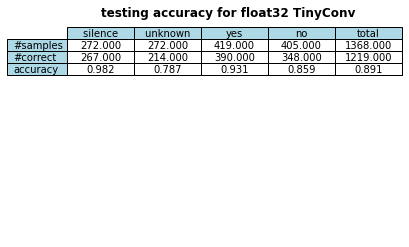

In [16]:
from src.train_val_test_utils import plot_acc

test_time_data_loaders = make_data_loaders(
    audio_processor, device, 
    test_batch_size=1, valid_batch_size=1,
    num_workers=0
)

plot_acc(
    test_time_data_loaders['validation'], model_fp32, audio_processor, device,
    "validation", 'float32 TinyConv', "float")
plot_acc(
    test_time_data_loaders['training'], model_fp32, audio_processor, device,
    "training", 'float32 TinyConv', "float")
acc = plot_acc(
    test_time_data_loaders['testing'], model_fp32, audio_processor, device,
    'testing', 'float32 TinyConv', "float")

## 3.6 Save the Trained Model

In [17]:
def choose_name(model_name):
    name = f"{model_name}_" + "{index}"
    i = 0
    while os.path.isfile(name.format(index=i)):
        i += 1
    name = name.format(index = i)
    print(f"The model's will be stored as: \n {name}")
    return name

def save_model(model, path):
    torch.save(model.state_dict(), path)

In [18]:
# Choose a path
# You can also define your own path
model_name = f"tinyconv_float32_init_seed{torch.initial_seed()}_{acc * 100:.2f}%"
file_name = choose_name(model_name)
torch_path = os.path.join(TORCH_DIR, f'{file_name}.pt')
torch_path

The model's will be stored as: 
 tinyconv_float32_init_seed0_89.11%_0


'/content/gdrive/MyDrive/ece5545/models/torch_models/tinyconv_float32_init_seed0_89.11%_0.pt'

In [19]:
# Save the trained pytorch model to torch_path
save_model(model_fp32, torch_path)
'Saved!'

'Saved!'

In [20]:
'You can now find your model in %s under the folder icon to the left.' % torch_path

'You can now find your model in /content/gdrive/MyDrive/ece5545/models/torch_models/tinyconv_float32_init_seed0_89.11%_0.pt under the folder icon to the left.'